## Resume PredictNextJob - Load Clean Data and Baseline, LSTM models
#### Resumes (300MB)


### Methodology


#### 1 <a href='#setup'>Initial Setup</a>
#### 2. <a href='#eda'>Exploratory Analysis</a>
#### 3. <a href='#baseline'>Baseline</a>
#### 4. <a href='#models'>LSTM Models</a>



<a id="setup"></a>
## Setup

Let's import the serialized data



In [ ]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries
import re
import string
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, json
import unicodedata
from collections import Counter

# NLTK library for stop word removal
from nltk.corpus import stopwords

# SK-learn libraries for learning.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import log_loss

from xml.dom import minidom
from bs4 import BeautifulSoup as BS




In [ ]:
import pickle
import sys

sys.setrecursionlimit(20000)
train_xml_ = pickle.load( open( "data/train_3_xml.p", "rb" ) )

In [ ]:
train_xml_ = pd.DataFrame(train_xml_)

# shuffle the training data to get rid of implicit order biases
train_data_original = train_xml_.sample(frac = 1)
train_data_original = train_data_original.reset_index()


In [ ]:
train_data_original.describe()

In [ ]:
# Lowercase the text
train_data_original['data'] = train_data_original['data'].apply(lambda x: x.lower())

# Attempt to remove css that is encased between {| and |
#train_data_original['data'] = train_data_original['data'].apply(lambda x: re.sub(re.compile('{|.*?|'),'',x))

# Removing line breaks
#train_data_original['data'] = train_data_original['data'].map(lambda x: x.splitlines()).astype(str)

# Remove html tags in <>
#train_data_original['data'] = train_data_original['data'].apply(lambda x: re.sub(re.compile('<.*?>'),'',x))

# Remove content in curly braces {}, which include entities and more css
#train_data_original['data'] = train_data_original['data'].apply(lambda x: re.sub(re.compile('{.*?}'),'',x))

# Remove indicators in HTML
# train_data_original['data'] = train_data_original['data'].str.replace('itemprop="worksfor"',' ')
# train_data_original['data'] = train_data_original['data'].str.replace('itemtype="http://schema.org/organization"',' ')
# train_data_original['data'] = train_data_original['data'].str.replace('itemscope',' ')
# train_data_original['data'] = train_data_original['data'].str.replace('present',' ')

train_data_original['plain_data'] = train_data_original['data'].apply(lambda x: re.sub('<[^<]+?>', '', x))



In [ ]:
print(train_data_original['data'][0])
print(train_data_original['plain_data'][0])
# print(train_data_original['data'][1])
# print(train_data_original['data'][2])

### Questions to Explore


- How many folks (%) have no previous experience?
- How many jobs do folks have on average?
- What is the average length of resume?

Resume Average Char Length: 6404.8
Resume Median Char Length: 5715.0
Resume Variance Char Length: 3406.2
Resume Min Char Length: 1083
Resume Max Char Length: 76324


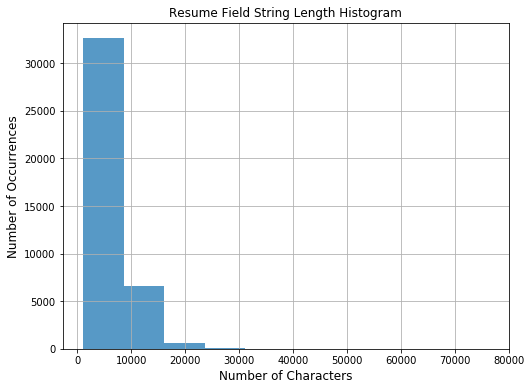

In [8]:
comment_length = train_data_original['data'].str.len()

plt.figure(figsize=(8,6))
plt.title("Resume Field String Length Histogram")
plt.ylabel('Number of Occurrences', fontsize = 12)
plt.xlabel('Number of Characters', fontsize = 12)
plt.grid(True)

counts, bins, bars = plt.hist(comment_length, alpha = 0.75)

print('Resume Average Char Length: ' + str(round(comment_length.mean(), 1)))
print('Resume Median Char Length: ' + str(round(comment_length.median(), 1)))
print('Resume Variance Char Length: ' + str(round(comment_length.std(), 1)))
print('Resume Min Char Length: ' + str(round(comment_length.min(), 1)))
print('Resume Max Char Length: ' + str(round(comment_length.max(), 1)))


### Predictor Variables EDA

In [ ]:
predictors = [];

for i in range(len(train_data_original)):
    predictors.append(train_data_original['predictions'][i])
    
predictors_ = pd.DataFrame(predictors)


In [ ]:
predictors_.describe()

### Potential Interesting Features

- whether or not you're going to stay at the same job
- whether you're going into a different job function
- whether you're going to stay at the same company
- whether you're going get promoted?

- level of candidate
- classification of candidate
- diversity?

- given their work experience, whether they have a college degree.


In [ ]:
len_ = int(len(train_data_original)/4)
print(len_)
train_data_ = train_data_original[len_:]
test_data_ = train_data_original[:len_]

predictors_train_ = predictors_[len_:]
predictors_test = predictors_[:len_]

print("training data:" + str(len(train_data_)))
print("test data:" + str(len(test_data_)))

model_results = []


In [ ]:
vectorizer_train = TfidfVectorizer(sublinear_tf = True, lowercase = True)
train_fit = vectorizer_train.fit(train_data_['data'])
train_transformed = vectorizer_train.transform(train_data_['data'])
dev_transformed = vectorizer_train.transform(test_data_['data'])
logis_regression = LogisticRegression()
logis_regression.fit(train_transformed, predictors_train_['similar_job'].astype(int))
pred = logis_regression.predict_proba(dev_transformed)
f1score_logis = logis_regression.score(dev_transformed, predictors_test['similar_job'].astype(int)) 
accuracy = round(f1score_logis, 6)
log_loss_ = round(log_loss(predictors_test['similar_job'].astype(int), pred), 6)

model_results.append({"accuracy" : accuracy, "name" : "TFIDF HTML - Predict Similar Job", "log_loss": log_loss_})


In [ ]:
print("Accuracy: " + str(accuracy))
print("Log Loss: " + str(log_loss_))

In [ ]:
vectorizer_train_plain = TfidfVectorizer(sublinear_tf = True, lowercase = True)
train_fit_plain = vectorizer_train_plain.fit(train_data_['plain_data'])
train_transformed_plain = vectorizer_train_plain.transform(train_data_['plain_data'])
dev_transformed_plain = vectorizer_train_plain.transform(test_data_['plain_data'])

logis_regression_plain = LogisticRegression()
logis_regression_plain.fit(train_transformed_plain, predictors_train_['similar_job'].astype(int))
pred_plain = logis_regression_plain.predict_proba(dev_transformed_plain)

f1score_logis = logis_regression_plain.score(dev_transformed_plain, predictors_test['similar_job'].astype(int))

accuracy = round(f1score_logis, 6)
log_loss_ = round(log_loss(predictors_test['similar_job'].astype(int), pred_plain), 6)

model_results.append({"accuracy" : accuracy, "name" : "TFIDF Plain Text - Predict Similar Job", "log_loss": log_loss_})


In [ ]:
print("Accuracy: " + str(accuracy))
print("Log Loss: " + str(log_loss_))

In [ ]:
print(sum(predictors_train_['similar_job'].astype(int)) / len(predictors_train_['similar_job'].astype(int)))


In [ ]:
print(sum(predictors_train_['similar_job'].astype(int)))

In [42]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

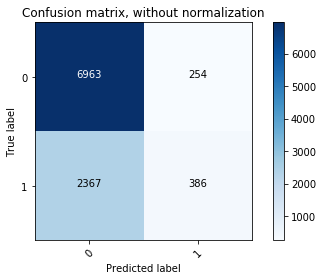

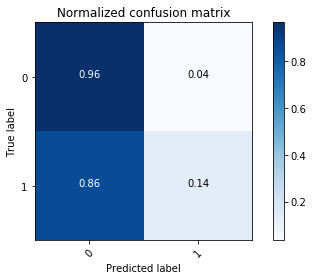

In [43]:
correct_values = predictors_test['similar_job'].astype(int)
logis_regression_pred = logis_regression.predict(dev_transformed) 

confusion_mat = confusion_matrix(correct_values, logis_regression_pred)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(confusion_mat, classes=[0,1], title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(confusion_mat, classes=[0,1], normalize=True, title='Normalized confusion matrix')

plt.show()


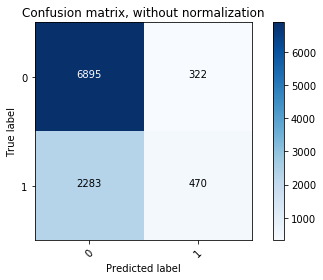

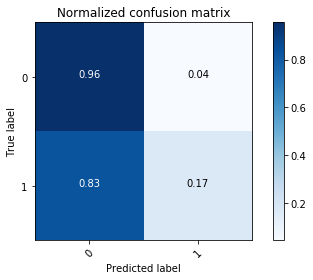

In [44]:
logis_regression_pred = logis_regression_plain.predict(dev_transformed_plain) 

confusion_mat = confusion_matrix(correct_values, logis_regression_pred)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(confusion_mat, classes=[0,1], title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(confusion_mat, classes=[0,1], normalize=True, title='Normalized confusion matrix')

plt.show()


In [45]:
# Print some examples of our vocabulary

def construct_columns_for_top_vocab(vectorizer_train, logis_regression):
    
    # Initialize empty helper vectors and get feature names
    feature_names = vectorizer_train.get_feature_names()
    num_top_features = 25
    all_indices = []
    all_indices_labels = []
    all_indices_values = []
    all_indices_values_with_labels = {}
    
    # https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
    indices = (-logis_regression.coef_[0]).argsort()[:num_top_features]
    all_indices.extend(indices)
            
    # Getting all the indices and then adding the feature names for each category
    for i, value in enumerate(all_indices):
        all_indices_labels.append(feature_names[value])
        all_indices_values.append([])
        all_indices_values[i].append(round(logis_regression.coef_[0][value], 3))
        all_indices_values_with_labels[feature_names[value]] = all_indices_values[i]
        
    return all_indices_values_with_labels


showValues = construct_columns_for_top_vocab(vectorizer_train, logis_regression)
df = pd.DataFrame.from_dict(showValues, orient='index')
display(df)

showValues = construct_columns_for_top_vocab(vectorizer_train_plain, logis_regression_plain)
df = pd.DataFrame.from_dict(showValues, orient='index')
display(df)

,0
nurse,2.181
driver,2.036
assistant,1.991
lpn,1.842
years,1.830
same,1.634
cna,1.626
truck,1.573
updated,1.507
cdl,1.461


,0
nurse,2.007
driver,1.848
assistant,1.803
same,1.713
lpn,1.615
registered,1.603
updated,1.586
catering,1.574
truck,1.559
tool,1.475


In [46]:
num_examples = 10
counter = 0

for i in range(len(train_data_original['data'])):
    if ('college' in train_data_original['data'][i]):        
        print(train_data_original['data'][i])
        print(train_data_original['plain_data'][i])
        counter += 1
    elif ('education' in train_data_original['data'][i]):  
        print(train_data_original['data'][i])
        print(train_data_original['plain_data'][i])
        counter += 1
        
    if counter > num_examples:
        break

<div class="vcard single_form-content" id="resume_body">
<div class="last basicinfo-content" id="basic_info_row"><div class="data_display" id="basic_info_cell">
<h1 class="fn " id="resume-contact" itemprop="name">40 hour medical assistant externship</h1>
<h2 id="headline" itemprop="jobtitle">40 hour medical assistant externship</h2>
<div id="contact_info_container">
<div class="adr" itemprop="address" itemscope="" itemtype="http://schema.org/postaladdress"><p class="locality" id="headline_location" itemprop="addresslocality">fort leonard wood, mo</p></div>
<div class="separator-hyphen">-</div>
</div>
</div></div>
<div class="section-item workexperience-content">
<div><div class="section_title"><h2>work experience</h2></div></div>
<div class="items-container" id="work-experience-items">
<div class="work-experience-section " id="workexperience-eeofndqundi_blpitwpljq"><div class="data_display">

<div class="work_company">
<span class="bold">doctors express urgent care</span> <div class="s

In [47]:


multinomial = MultinomialNB()
multinomial.fit(train_transformed, predictors_train_['similar_job'].astype(int))
f1score_multi = multinomial.score(dev_transformed, predictors_test['similar_job'].astype(int)) 

pred_multi = multinomial.predict_proba(dev_transformed)

accuracy = round(f1score_multi, 6)
log_loss_ = round(log_loss(predictors_test['similar_job'].astype(int), pred_multi), 6)

print("Accuracy: " + str(accuracy))
print("Log Loss: " + str(log_loss_))
model_results.append({"accuracy" : accuracy, "name" : "TFIDF HTML NB - Predict Similar Job", "log_loss": log_loss_})


Accuracy: 0.723872
Log Loss: 2.046691


In [48]:
multinomial_plain = MultinomialNB()
multinomial_plain.fit(train_transformed_plain, predictors_train_['similar_job'].astype(int))
f1score_multi = multinomial_plain.score(dev_transformed_plain, predictors_test['similar_job'].astype(int)) 

pred_plain_multi = multinomial_plain.predict_proba(dev_transformed_plain)

accuracy = round(f1score_multi, 6)
log_loss_ = round(log_loss(predictors_test['similar_job'].astype(int), pred_plain_multi), 6)

print("Accuracy: " + str(accuracy))
print("Log Loss: " + str(log_loss_))
model_results.append({"accuracy" : accuracy, "name" : "TFIDF Plain NB - Predict Similar Job", "log_loss": log_loss_})


Accuracy: 0.725376
Log Loss: 1.21057


In [49]:
showValues = construct_columns_for_top_vocab(vectorizer_train, multinomial)
df = pd.DataFrame.from_dict(showValues, orient='index')
display(df)


,0
div,-6.681
class,-6.752
span,-7.021
id,-7.049
itemprop,-7.190
br,-7.191
section,-7.231
to,-7.232
and,-7.233
separator,-7.290


In [50]:
showValues = construct_columns_for_top_vocab(vectorizer_train_plain, multinomial_plain)
df = pd.DataFrame.from_dict(showValues, orient='index')
display(df)

,0
to,-6.423
and,-6.456
in,-6.762
of,-6.770
the,-6.811
for,-6.857
with,-6.977
work,-7.038
skills,-7.214
as,-7.243


In [ ]:
from sklearn.base import TransformerMixin
from sklearn.pipeline import FeatureUnion


In [ ]:
# Loading list of stopwords from nltk corpus
stop_words = stopwords.words('english')

# Helper function for finding the percent of stop words in the message
def contains_stop_words(x):
    count = 0
    
    tokens = x.lower().split()
    for value in tokens:
        if value in stop_words:
            count = count + 1
    
    return count / float(len(tokens))

# The word length function for counting how long individual words are
def word_length(x):
    total_chars = len(x)
    num_words = len(x.split())
    return total_chars / float(num_words)

# Helper function for finding the number of unique words
def unique_words(x):
    num_words = len(set(x.lower().split()))
    return num_words

def capitalized_percent(x):
    total_chars = len(x)
    num_capi = len(re.findall(r'[A-Z]', x))
    return num_capi / float(total_chars)

# Helper function for calculating the percent of non-alpha numeric characters
def non_alphanumeric_percent(x):
    total_chars = len(x)
    num_special = len(re.findall(r'[^0-9a-zA-Z ]', x))
    return num_special / float(total_chars)

# Helper function for calculating the percent of non-alpha numeric non-period, comma, dash characters
def non_alphanumeric_noperiodscommas_percent(x):
    total_chars = len(x)
    num_special = len(re.findall(r'[^0-9a-zA-Z.,-/ ]', x))
    return num_special / float(total_chars)

# Helper function for calculating the percent of non-alpha-numeric specific punctuation characters
def non_alphanumeric_specificpunc_percent(x):
    total_chars = len(x)
    num_special = len(re.findall(r'[!@$%&*]', x))
    return num_special / float(total_chars)

# Helper function for calculating the percent of just ! characters
def non_alphanumeric_just_exclamation_percent(x):
    total_chars = len(x)
    num_special = len(re.findall(r'[!]', x))
    return num_special / float(total_chars)

# Class transformer for TextLengthTransformer
class TextLengthTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        feature = np.array(X.apply(lambda x: len(x) > 150 )).reshape(-1,1)
        return feature

    def fit(self, X, y=None, **fit_params):
        return self

# Class transformer for TokenLengthTransformer
class TokenLengthTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        feature = np.array(X.apply(lambda x: len([word for word in x.split() if word]))).reshape(-1,1)
        return feature

    def fit(self, X, y=None, **fit_params):
        return self

# Class transformer for AverageWordLengthTransformer
class AverageWordLengthTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        feature = np.array(X.apply(lambda x: word_length(x))).reshape(-1,1)
        return feature

    def fit(self, X, y=None, **fit_params):
        return self

# Class transformer for AverageWordLengthNormalTransformer
class AverageWordLengthNormalTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        feature = np.array(X.apply(lambda x: word_length(x) > 100)).reshape(-1,1)
        return feature

    def fit(self, X, y=None, **fit_params):
        return self
    
# Class transformer for CapitalizedPercentTransformer
class CapitalizedPercentTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        feature = np.array(X.apply(lambda x: capitalized_percent(x))).reshape(-1,1)
        return feature

    def fit(self, X, y=None, **fit_params):
        return self

# Class transformer for SpecificPunctuationTransformer
class SpecificPunctuationTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        feature = np.array(X.apply(lambda x: non_alphanumeric_specificpunc_percent(x))).reshape(-1,1)
        return feature

    def fit(self, X, y=None, **fit_params):
        return self

# Class transformer for SpecificPunctuationExclamaTransformer
class SpecificPunctuationExclamaTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        feature = np.array(X.apply(lambda x: non_alphanumeric_just_exclamation_percent(x))).reshape(-1,1)
        return feature

    def fit(self, X, y=None, **fit_params):
        return self

# Class transformer for UniqueWordsTransformer
class UniqueWordsTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        feature = np.array(X.apply(lambda x: unique_words(x))).reshape(-1,1)
        return feature

    def fit(self, X, y=None, **fit_params):
        return self
    
# Class transformer for ContainsStopWordsTransformer
class ContainsStopWordsTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        feature = np.array(X.apply(lambda x: contains_stop_words(x))).reshape(-1,1)
        return feature

    def fit(self, X, y=None, **fit_params):
        return self

class SpecificPunctuationTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        feature = np.array(X.apply(lambda x: non_alphanumeric_specificpunc_percent(x))).reshape(-1,1)
        return feature

    def fit(self, X, y=None, **fit_params):
        return self


In [ ]:
pipe_all = Pipeline([
    ('features', FeatureUnion([
        ('TextLength', TextLengthTransformer()),
        ('TokenLength', TokenLengthTransformer()),
        ('AverageWordLength', AverageWordLengthTransformer()),
        ('AverageWordLengthNormal', AverageWordLengthNormalTransformer()),
        ('UniqueWords', UniqueWordsTransformer()),
        ('tfdif_features', Pipeline([
            ('cv', CountVectorizer()),
            ('tfidf', TfidfTransformer(sublinear_tf = True)),
        ])),
    ])),
    ('logit', LogisticRegression()),

])

pipe_all.fit(train_data_['plain_data'], predictors_train_['similar_job'].astype(int))
f1score_logis = pipe_all.score(test_data_['plain_data'], predictors_test['similar_job'].astype(int))
pred_pipe = pipe_all.predict_proba(test_data_['plain_data'])

accuracy = round(f1score_logis, 6)
log_loss_ = round(log_loss(predictors_test['similar_job'].astype(int), pred_pipe), 6)

print("Accuracy: " + str(accuracy))
print("Log Loss: " + str(log_loss_))
model_results.append({"accuracy" : accuracy, "name" : "TFIDF Plain Log Pipeline [*all] - Predict Similar Job", "log_loss": log_loss_})



In [ ]:
pipe_all = Pipeline([
    ('features', FeatureUnion([
        ('TextLength', TextLengthTransformer()),
        ('TokenLength', TokenLengthTransformer()),
        ('AverageWordLength', AverageWordLengthTransformer()),
        ('AverageWordLengthNormal', AverageWordLengthNormalTransformer()),
        ('UniqueWords', UniqueWordsTransformer()),
        ('tfdif_features', Pipeline([
            ('cv', CountVectorizer()),
            ('tfidf', TfidfTransformer(sublinear_tf = True)),
        ])),
    ])),
    ('logit', LogisticRegression()),

])

pipe_all.fit(train_data_['data'], predictors_train_['similar_job'].astype(int))
f1score_logis = pipe_all.score(test_data_['data'], predictors_test['similar_job'].astype(int))
pred_pipe = pipe_all.predict_proba(test_data_['data'])

accuracy = round(f1score_logis, 6)
log_loss_ = round(log_loss(predictors_test['similar_job'].astype(int), pred_pipe), 6)

print("Accuracy: " + str(accuracy))
print("Log Loss: " + str(log_loss_))
model_results.append({"accuracy" : accuracy, "name" : "TFIDF HTML Log Pipeline [*all] - Predict Similar Job", "log_loss": log_loss_})



In [ ]:
model_results

In [56]:
import gensim.models.keyedvectors as word2vec
import keras
import gc

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

# load word2vec, slimmed down version for performance reasons
word2vecDict = word2vec.KeyedVectors.load_word2vec_format("data/GoogleNews-vectors-negative300-SLIM.bin", binary = True)
embedding_dictionary = dict()

# create the embeddings index from word2vec vocabulary
for word in word2vecDict.wv.vocab:
    embedding_dictionary[word] = word2vecDict.word_vec(word)

### TUNABLE PARAMETERS WE DID NOT TUNE DUE TO RUN TIME DURATION
max_length_cutoff = 200
batch_size = 32
epochs = 3
vocab_size = 16000
embedding_layer = 300


/Users/sxc2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [57]:
# https://www.kaggle.com/amberhahn/using-f-score-to-evaluate-the-lstm-model
def model_F_score(newp,newy_test):
    TP=0
    FN=0
    FP=0
    for i in range(len(newp)-1):
        test_prof=newy_test[i+1]-newy_test[i]
        p_prof=newp[i+1] - newp[i]

        if((test_prof>=0) and (p_prof>=0)):
            TP=TP+1
        if ((test_prof>= 0) and (p_prof<0)):
            FN=FN+1
        if ((test_prof<0) and (p_prof>=0)):
            FP=FP+1

    Precision=float(TP)/float(TP+FP)
    Recall=float(TP)/float(TP+FN)

    Fscore= 2.0*Precision*Recall/(Precision+Recall)
    print('classification F score: %.5f' % (Fscore))
    return Fscore



In [58]:
model_predictions = {}

In [59]:
from keras import backend as K

# https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [60]:
def train_lstm_rnn(_epochs, _embedding_layer, data_name, _max_length_cutoff, _optimizer, _dropout):

    global model_results
    global embedding_dictionary
    
    tokenizer_ = Tokenizer(num_words = vocab_size)
    tokenizer_.fit_on_texts(list(train_data_[data_name]))

    # for training and test data
    list_tokenized_train_ = tokenizer_.texts_to_sequences(train_data_[data_name])
    tokenized_padded_train_ = pad_sequences(list_tokenized_train_, maxlen = _max_length_cutoff)

    list_tokenized_test_ = tokenizer_.texts_to_sequences(test_data_[data_name])
    tokenized_padded_test_ = pad_sequences(list_tokenized_test_, maxlen = _max_length_cutoff)

    number_words_ = len(tokenizer_.word_index)
    embedding_values_ = np.stack(list(embedding_dictionary.values()))
    
    _mean, _std = embedding_values_.mean(), embedding_values_.std()
    embedding_matrix_ = np.random.normal(_mean, _std, (number_words_, _embedding_layer))

    for word, index in tokenizer_.word_index.items():
        index = index - 1
        embedding_vector = embedding_dictionary.get(word)
        if embedding_vector is not None: 
            embedding_matrix_[index] = embedding_vector

    sequence_input_ = Input(shape = (_max_length_cutoff, ))
    x_ = Embedding(len(tokenizer_.word_index), 
                  embedding_matrix_.shape[1], weights = [embedding_matrix_], trainable = False)(sequence_input_)

    x_ = Bidirectional(
        LSTM(60, return_sequences = True, name='lstm_layer', dropout = _dropout, recurrent_dropout = _dropout))(x_)

    x_ = GlobalMaxPool1D()(x_)
    x_ = Dropout(_dropout)(x_)
    x_ = Dense(50, activation = "relu")(x_)
    x_ = Dropout(_dropout)(x_)

    # one output node
    x_ = Dense(1, activation = "sigmoid")(x_)
    model_ = Model(inputs = sequence_input_, outputs = x_)
    model_.compile(loss = 'binary_crossentropy',
                      optimizer = _optimizer,
                      metrics = ['accuracy', 'cosine_proximity', f1])

    # a look at the RNN we're building and its structure
    model_.summary()

    lstm_nn_plain = model_.fit(tokenized_padded_train_, 
                        predictors_train_['similar_job'], 
                        batch_size = batch_size, epochs = _epochs, validation_split = 0.1)
    lstm_nn_pred_plain = model_.predict(tokenized_padded_test_)
    accuracy = model_F_score(predictors_test['similar_job'].astype(int), lstm_nn_pred_plain)
    
    model_details_ = "CO:" + str(_max_length_cutoff) + ", E:" + str(_epochs) + ", " + data_name + ", " + _optimizer
    model_predictions[model_details_] = lstm_nn_pred_plain
    model_results.append({"F1 accuracy" : accuracy, "name" : "LSTM: " + model_details_ + " - Predict Similar Job"})




In [61]:
train_lstm_rnn(5, 300, 'data', 400, "adam", 0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 400, 300)          111701700 
_________________________________________________________________
bidirectional_2 (Bidirection (None, 400, 120)          173280    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 120)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                6050      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
__________

In [62]:
train_lstm_rnn(5, 300, 'plain_data', 400, "adam", 0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 400, 300)          80773500  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 400, 120)          173280    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 120)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                6050      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
__________

In [63]:
train_lstm_rnn(5, 300, 'data', 800, "adam", 0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 800)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 800, 300)          111701700 
_________________________________________________________________
bidirectional_4 (Bidirection (None, 800, 120)          173280    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 120)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                6050      
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
__________

In [64]:
train_lstm_rnn(5, 300, 'plain_data', 800, "adam", 0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 800)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 800, 300)          80773500  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 800, 120)          173280    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 120)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                6050      
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
__________

In [65]:
train_lstm_rnn(10, 300, 'data', 800, "adam", 0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 800)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 800, 300)          111701700 
_________________________________________________________________
bidirectional_6 (Bidirection (None, 800, 120)          173280    
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 120)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                6050      
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
__________

In [66]:
train_lstm_rnn(10, 300, 'plain_data', 800, "adam", 0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 800)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 800, 300)          80773500  
_________________________________________________________________
bidirectional_7 (Bidirection (None, 800, 120)          173280    
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 120)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                6050      
_________________________________________________________________
dropout_14 (Dropout)         (None, 50)                0         
__________

In [67]:
train_lstm_rnn(15, 300, 'data', 400, "adam", 0.05)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 400, 300)          111701700 
_________________________________________________________________
bidirectional_8 (Bidirection (None, 400, 120)          173280    
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 120)               0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 50)                6050      
_________________________________________________________________
dropout_16 (Dropout)         (None, 50)                0         
__________

In [68]:
train_lstm_rnn(15, 300, 'plain_data', 400, "adam", 0.05)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 400, 300)          80773500  
_________________________________________________________________
bidirectional_9 (Bidirection (None, 400, 120)          173280    
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 120)               0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 50)                6050      
_________________________________________________________________
dropout_18 (Dropout)         (None, 50)                0         
__________

In [69]:
model_results


[{'accuracy': 0.737111,
  'name': 'TFIDF HTML - Predict Similar Job',
  'log_loss': 0.548248},
 {'accuracy': 0.737111,
  'name': 'TFIDF HTML - Predict Similar Job',
  'log_loss': 0.548248},
 {'accuracy': 0.738716,
  'name': 'TFIDF Plain Text - Predict Similar Job',
  'log_loss': 0.545978},
 {'accuracy': 0.723872,
  'name': 'TFIDF HTML NB - Predict Similar Job',
  'log_loss': 2.046691},
 {'accuracy': 0.725376,
  'name': 'TFIDF Plain NB - Predict Similar Job',
  'log_loss': 1.21057},
 {'accuracy': 0.742227,
  'name': 'TFIDF Plain Log Pipeline [*all] - Predict Similar Job',
  'log_loss': 0.543057},
 {'accuracy': 0.740321,
  'name': 'TFIDF HTML Log Pipeline [*all] - Predict Similar Job',
  'log_loss': 0.541712},
 {'F1 accuracy': 0.6652793834296724,
  'name': 'LSTM: CO:400, E:5, data, adam - Predict Similar Job'},
 {'F1 accuracy': 0.6694967582587219,
  'name': 'LSTM: CO:400, E:5, plain_data, adam - Predict Similar Job'},
 {'F1 accuracy': 0.673916396729909,
  'name': 'LSTM: CO:800, E:5, data

In [70]:
model_predictions

{'CO:400, E:5, data, adam': array([[0.25],
        [0.25],
        [0.31],
        ...,
        [0.44],
        [0.78],
        [0.23]], dtype=float32),
 'CO:400, E:5, plain_data, adam': array([[0.25],
        [0.16],
        [0.12],
        ...,
        [0.21],
        [0.65],
        [0.11]], dtype=float32),
 'CO:800, E:5, data, adam': array([[0.25],
        [0.15],
        [0.23],
        ...,
        [0.39],
        [0.61],
        [0.19]], dtype=float32),
 'CO:800, E:5, plain_data, adam': array([[0.38],
        [0.21],
        [0.24],
        ...,
        [0.24],
        [0.76],
        [0.14]], dtype=float32),
 'CO:800, E:10, data, adam': array([[0.23],
        [0.07],
        [0.09],
        ...,
        [0.38],
        [0.79],
        [0.05]], dtype=float32),
 'CO:800, E:10, plain_data, adam': array([[0.31],
        [0.13],
        [0.18],
        ...,
        [0.41],
        [0.83],
        [0.1 ]], dtype=float32),
 'CO:400, E:15, data, adam': array([[0.63],
        [0.08],
  

In [71]:
def score_accuracy(pred, actual):
    total = 0.0
    correct = 0.0
    for index, value in enumerate(pred):
        if (actual[index] == round(value[0])):
            correct += 1
        total += 1
    return correct / total

In [72]:
for index in model_predictions:
    score = score_accuracy(model_predictions[index], predictors_test['similar_job'].astype(int))
    print(str(index) + " score: " + str(score))

CO:400, E:5, data, adam score: 0.7267803410230692
CO:400, E:5, plain_data, adam score: 0.7303911735205617
CO:800, E:5, data, adam score: 0.7315947843530591
CO:800, E:5, plain_data, adam score: 0.7360080240722167
CO:800, E:10, data, adam score: 0.7348044132397191
CO:800, E:10, plain_data, adam score: 0.7311935807422267
CO:400, E:15, data, adam score: 0.6703109327983952
CO:400, E:15, plain_data, adam score: 0.6969909729187562
